In [1]:
''' Visualize reward design in dummy environment '''

import argparse
import datetime
import os
import pickle
import random
import pandas as pd
import numpy as np
import tensorflow as tf

from simulated_patient_database import DummyClassifier
from utils.general import get_logger
%matplotlib inline
import matplotlib.pyplot as plt
from utils.plotting import _plot_element


In [2]:
def parse_args(rand=False):
    parser = argparse.ArgumentParser(description='K Tails Dueling DQN dummy')

    # basic -----------------------
    parser.add_argument('--seed', type=int, default=0)
    parser.add_argument('--debug', type=int, default=0)

    # Model
    parser.add_argument('--state_dim', type=int, default=30)
    parser.add_argument('--action_dim', type=int, default=6)

    parser.add_argument('--gamma', type=float, default=0.999)  # todo: change back to 0.99 when down
    parser.add_argument('--memory_size', type=int, default=10000)

    # Training spec
    parser.add_argument('--num_shared_all_layers', type=int, default=1)
    parser.add_argument('--num_shared_dueling_layers', type=int, default=2)
    parser.add_argument('--num_hidden_units', type=int, default=64)

    parser.add_argument('--lr', type=float, default=1e-5)
    parser.add_argument('--reg_constant', type=float, default=1e-5)
    parser.add_argument('--keep_prob', type=float, default=0.5)
    parser.add_argument('--train_batch_size', type=int, default=64)
    parser.add_argument('--val_batch_size', type=int, default=5000)
    parser.add_argument('--max_training_iters', type=int, default=20000)
    parser.add_argument('--replace_target_batch', type=int, default=500)
    parser.add_argument('--early_stopping_epochs', type=int, default=50)

    # reward design
    parser.add_argument('--reward_param_1', type=float, default=25.0)
    parser.add_argument('--reward_param_2', type=float, default=8.0)

    # Experience --------------------------------
    parser.add_argument('--data_keep_rate', type=float, default=0.5)

    args = parser.parse_args([])
    args.exp_fname = '../data/simulated_disease/1012_simulated_6features_dummy_k{}.pkl'.format(args.data_keep_rate)
    args.exp_hypermarameters = '../data/simulated_disease/1012_hyperparameters.pkl'

    return args

In [3]:
def reward_func(cur_action, information_gain, label, class1_prob=None):

    information_gain = args.reward_param_1 * information_gain
    information_gain = (1 - label) * information_gain + label * information_gain * args.reward_param_2

    action_cost = - cur_action
    return information_gain + action_cost


def reward_func_early_detection(cur_action, information_gain, label, class1_prob):
    pass

In [4]:
args = parse_args()
np.random.seed(args.seed)
tf.set_random_seed(args.seed)
data_dict = pickle.load((open(args.exp_fname, 'rb')))
data_dict_val = data_dict['val']

cly_args = pickle.load(open(args.exp_hypermarameters, 'rb'))

classifier = DummyClassifier(num_useful_features=cly_args.num_useful_features,
                             num_noisy_features=cly_args.num_noisy_features,
                             obs_t_dim=cly_args.max_num_terminal_states,
                             score_param_1=cly_args.score_param_1)

In [5]:
data_dict_val.keys()

dict_keys(['cur_state', 'next_state', 'actions', 'labels', 'ind', 'idx', 'gain', 'class1_prob'])

In [6]:
data_dict_val['idx']

array([ 0,  1,  2, ..., 17, 18, 19])

In [7]:
threshold = classifier.find_prob_threshold(obs=data_dict_val['next_state'], label=data_dict_val['labels'], precision=0.5)

Picked - precision: 0.5026715988491575, recall: 0.9000919963201472, threshold: 0.425557483188341


In [8]:
exp = data_dict_val

results = {k: [] for k in ['accuracy', 'early_detection_time',
                           'time_to_death', 'all_action_cost',
                           'action_cost_till_detection']}

to_1d = lambda x: x[:, 0] if len(x.shape) == 2 else x

reward = reward_func(exp['actions'], exp['gain'], exp['labels'])

df = pd.DataFrame({k: to_1d(exp[k]) for k in ['idx', 'labels', 'class1_prob','ind']})
df['detect'] = df.apply(lambda x: x['labels'] == 1 and (x['class1_prob'] >= threshold), axis=1)
df['num_actions'] = np.sum(exp['actions'], axis=1)
df['num_useful_actions'] = np.sum(exp['actions'][:, :3], axis=1)

df['reward'] = np.sum(reward, axis=1)
df['gain'] = np.sum(exp['gain'], axis=1)
first_detet = df.groupby('ind')['detect'].apply(lambda x: np.argmax(x.values) if np.max(x.values) == 1 else None)
df = df.join(first_detet, on='ind', rsuffix='_first')

#time_till_death = df.groupby('idx').apply(lambda x: np.arange(-len(x), 0, 1))
df['time_till_death'] = df.groupby('ind')['idx'].apply(lambda x: x - np.max(x))


# df.groupby('user')['display'].apply(lambda x: np.argmax(x.values))
#results['accuracy'] = df.gorupby('idx')['pred_labels']

In [9]:
will_die = df.groupby('ind')['labels'].apply(lambda x: np.any(x))
df = df.join(will_die, on='ind', rsuffix='_end')


In [10]:
df = df[df['labels_end']==1]

In [11]:
def plot_by_group(df, num_groups, var1: str, var2: str, **kwargs):
    plt.figure()
    grouup_to_plot = [g[1] for g in list(df.groupby('ind'))[:num_groups]]
    for g in grouup_to_plot:
        plt.plot(g[var1], g[var2])
    plt.grid(True)
    _plot_element(**kwargs)
    
    plt.show()

def scatter_by_group(df, num_groups, var1: str, var2: str, **kwargs):
    plt.figure()
    grouup_to_plot = [g[1] for g in list(df.groupby('ind'))[:num_groups]]
    for g in grouup_to_plot:
        plt.scatter(g[var1], g[var2])
    plt.grid(True)
    _plot_element(**kwargs)
    
    plt.show()

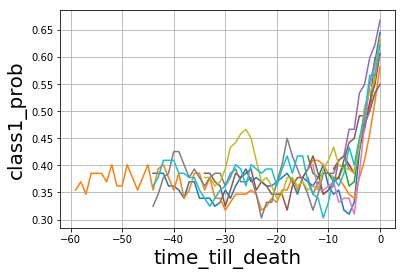

In [12]:
plot_by_group(df, 10, 'time_till_death', 'class1_prob', xlabel='time_till_death', ylabel='class1_prob')

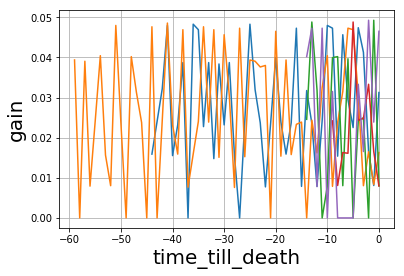

In [13]:
plot_by_group(df, 5, 'time_till_death', 'gain', xlabel='time_till_death', ylabel='gain')

In [14]:
# scatter plot: accuracy per trajectory vs sum of gain
accuracy = df.groupby('ind').apply(lambda x: np.mean(x['labels'] == x['detect']))
sum_of_gain = df.groupby('ind').apply(lambda x: np.sum(x['gain']))

In [15]:
def scatter_simple(var1, var2, color=None, **kwargs):
    plt.figure(figsize=(20,8))
    plt.scatter(var1, var2, color, cmap='viridis')
    _plot_element(**kwargs)
    plt.show()

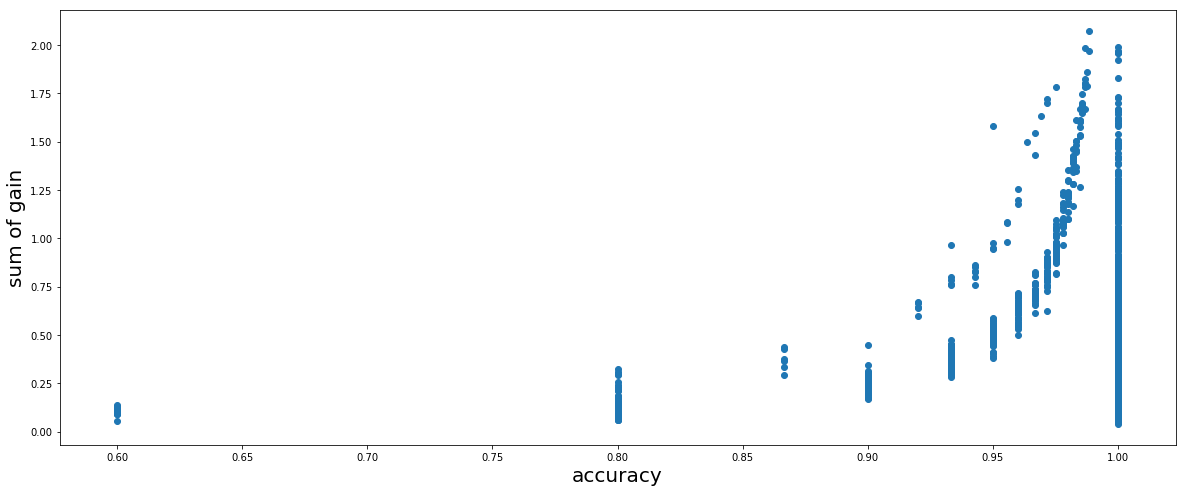

In [16]:
scatter_simple(accuracy, sum_of_gain, xlabel='accuracy', ylabel='sum of gain')

In [17]:
df['mask_action'] = (df['idx'] <= df['detect_first']) * df['num_actions']

In [19]:
df.head(5)

,idx,labels,class1_prob,ind,detect,num_actions,num_useful_actions,reward,gain,detect_first,time_till_death,labels_end,mask_action
0,0,False,0.393331,3576,False,2,1,-1.397521,0.024099,15.0,-19,True,2
1,1,False,0.377541,3576,False,5,3,-3.785410,0.048584,15.0,-18,True,5
2,2,False,0.369740,3576,False,3,2,-2.407122,0.023715,15.0,-17,True,3
3,3,False,0.339244,3576,False,3,2,-2.031717,0.038731,15.0,-16,True,3
4,4,False,0.317201,3576,False,4,3,-2.858086,0.045677,15.0,-15,True,4


In [20]:
traj_len = df.groupby('ind')['idx'].apply(lambda x: len(x))

df = df.join(traj_len, on='ind', rsuffix='_max')

In [21]:
df['early_detect_reward'] = df.apply(lambda x: x['idx_max'] - x['idx'] if x['idx'] == x['detect_first'] else 0,axis=1)

In [22]:
early_reward = df.groupby('ind')['early_detect_reward'].apply(lambda x: np.sum(x))
reward_sum = df.groupby('ind')['reward'].apply(lambda x: np.sum(x))

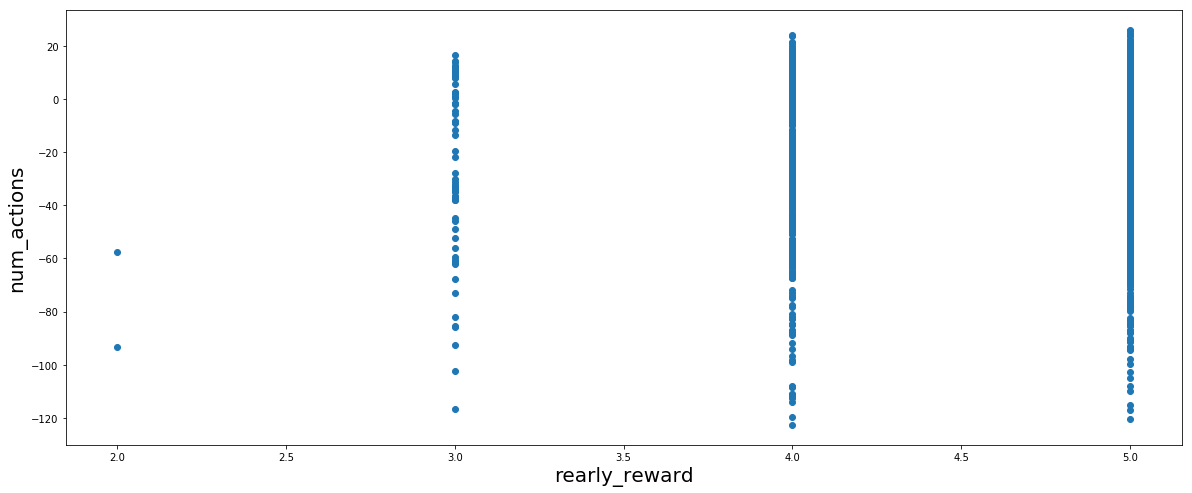

In [24]:
scatter_simple(early_reward, reward_sum, xlabel='rearly_reward', ylabel='num_actions')